In [1]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date

from datetime import timedelta

import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Obtaining stock data from alpha vantage 
# //s&P 500
stock='VOO'


def stock_data(stock):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=stock, outputsize='full')
    data_date_changed = data[:'2010-01-01']
    data_date_changed['Ticker']= stock
    return data_date_changed


In [6]:
raw_data= stock_data(stock)
raw_data.reset_index(inplace = True) 

In [7]:
raw_data.head(10)

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
0,2021-02-24,355.15,360.58,354.2000,360.16,360.16,3301220.0,0.0,1.0,VOO
1,2021-02-23,353.69,357.56,349.5300,356.22,356.22,5251055.0,0.0,1.0,VOO
2,2021-02-22,355.84,358.19,355.5600,355.77,355.77,3231900.0,0.0,1.0,VOO
3,2021-02-19,360.47,360.71,358.1400,358.59,358.59,2487098.0,0.0,1.0,VOO
4,2021-02-18,358.24,359.93,356.4900,359.25,359.25,3017068.0,0.0,1.0,VOO
5,2021-02-17,359.03,360.97,357.9222,360.79,360.79,3208028.0,0.0,1.0,VOO
6,2021-02-16,362.15,362.37,359.9800,360.71,360.71,4408452.0,0.0,1.0,VOO
7,2021-02-12,358.45,361.19,358.3600,361.05,361.05,2144471.0,0.0,1.0,VOO
8,2021-02-11,359.71,360.10,356.8376,359.22,359.22,2237200.0,0.0,1.0,VOO
9,2021-02-10,360.53,360.61,356.3000,358.64,358.64,2388804.0,0.0,1.0,VOO


In [8]:
raw_data.sort_index(inplace=True)
raw_data.sort_values(by = ['date'], inplace = True)

In [9]:
# define the number of days out you want to predict
days_out = 90

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = raw_data.groupby(['Ticker'])[['4. close','3. low','2. high','1. open','6. volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([raw_data[['Ticker','date']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,Ticker,date,4. close,3. low,2. high,1. open,6. volume
2632,VOO,2010-09-09,50.660000,50.570000,51.250000,51.250000,5.300000e+04
2631,VOO,2010-09-10,50.776278,50.609433,51.088222,51.042722,3.490111e+04
2630,VOO,2010-09-13,51.033122,50.827718,51.252397,51.191732,4.597569e+04
2629,VOO,2010-09-14,51.158670,50.921330,51.378391,51.250715,6.479308e+04
2628,VOO,2010-09-15,51.261352,50.979568,51.443513,51.263105,5.509755e+04
...,...,...,...,...,...,...,...
4,VOO,2021-02-18,337.774009,335.717411,339.388885,337.732932,3.184251e+06
3,VOO,2021-02-19,338.231503,336.210215,339.857481,338.232647,3.168929e+06
2,VOO,2021-02-22,338.616965,336.635485,340.260393,338.619622,3.170313e+06
1,VOO,2021-02-23,339.003845,336.918881,340.640604,338.950839,3.216044e+06


/Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Signal_Flag', ylabel='count'>

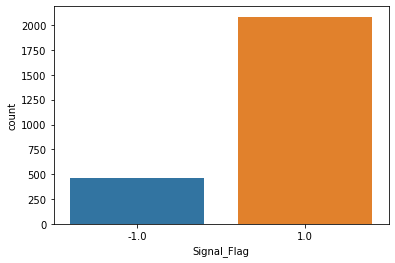

In [10]:
# define the number of days out you want to predict
# days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
import seaborn as sns

sns.countplot(smoothed_df['Signal_Flag'])

In [11]:
smoothed_df = smoothed_df[smoothed_df['Signal_Flag'].notna()]

In [12]:
smoothed_df.head(10)

,Ticker,date,4. close,3. low,2. high,1. open,6. volume,Signal_Flag
2542,VOO,2011-01-18,56.172033,55.898876,56.323671,56.125388,176930.438939,1.0
2541,VOO,2011-01-19,56.234844,55.964796,56.397549,56.203514,178113.702194,1.0
2540,VOO,2011-01-20,56.294058,56.020050,56.455235,56.262309,178835.554080,1.0
2539,VOO,2011-01-21,56.354909,56.086270,56.520823,56.329726,180264.435438,1.0
2538,VOO,2011-01-24,56.423053,56.151379,56.585319,56.388997,198557.271037,1.0
2537,VOO,2011-01-25,56.488794,56.212425,56.648011,56.451598,204900.677645,1.0
2536,VOO,2011-01-26,56.560413,56.284699,56.718158,56.520413,205236.232928,1.0
2535,VOO,2011-01-27,56.632033,56.357948,56.788248,56.590299,214881.980638,1.0
2534,VOO,2011-01-28,56.675781,56.406938,56.857992,56.663205,253635.321077,1.0
2533,VOO,2011-01-31,56.729373,56.457765,56.908325,56.711191,254309.831240,1.0


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

# Grab our X & Y Columns.
X_Cols = smoothed_df[['4. close','3. low','2. high','1. open','6. volume']]
Y_Cols = smoothed_df['Signal_Flag']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [14]:

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  98.74213836477988


In [15]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

6. volume    0.370555
3. low       0.212908
4. close     0.159209
1. open      0.130345
2. high      0.126983
dtype: float64

In [16]:
y_train[1]

1.0

In [17]:
type(y_test)

pandas.core.series.Series

In [18]:
y_test.head(5)

480    -1.0
2062    1.0
498    -1.0
1659    1.0
92      1.0
Name: Signal_Flag, dtype: float64